In [ ]:
# this code make scatter plots for true vs predicted values for many models

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, IterableDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
import seaborn as sns

%matplotlib inline

2025-11-22 18:06:29.747997: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sns.set_theme(style="white", palette='tab10')
#-------------------------------------------------------------------------------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
else:
    print('No GPU found for TensorFlow.')

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('\nUsing device:', device)

No GPU found for TensorFlow.

Using device: cuda:0


In [3]:
class IterTensorFlowToPyTorchDataset(IterableDataset):
    def __init__(self, tf_dataset_path):
        """
        A PyTorch dataset that fetches data from a TensorFlow dataset.
        
        Args:
        - tf_dataset: A TensorFlow dataset.
        """
        self.tf_path = tf_dataset_path
        self.tf_dataset = tf.data.Dataset.load(tf_dataset_path)
        
        
    def __len__(self):
        return tf.data.experimental.cardinality(self.tf_dataset).numpy()
            
    def __iter__(self):
        for element in self.tf_dataset.as_numpy_iterator():
            features, labels = element
            features = torch.tensor(features, dtype=torch.float32).view(1, -1)  # Reshape to match model input shape
            labels = torch.tensor(labels, dtype=torch.float32)
            
            # # Normalize the labels
            # labels = self.output_normalization(labels)
    
            yield features, labels
    
    def size(self, in_gb=False):
        ''' Returns the size of the Dataset in MB or GB.
        '''
        if os.path.exists(self.tf_path):
            if os.path.isfile(self.tf_path):
                # If it's a single file
                size_in_bytes = os.path.getsize(self.tf_path)
            elif os.path.isdir(self.tf_path):
                # If it's a directory, sum up the sizes of all files inside it
                size_in_bytes = sum(
                    os.path.getsize(os.path.join(root, file))
                    for root, _, files in os.walk(self.tf_path)
                    for file in files
                )
            else:
                raise ValueError(f"Path '{self.tf_path}' is neither a file nor a directory.")
            
                            
            if in_gb == False:
                size_in_mb = size_in_bytes / (1024*1024) # Convert to MB
                return size_in_mb
            else:
                size_in_gb = size_in_bytes / (1024*1024*1024) # Convert to GB
                return size_in_gb
        else:
            raise FileNotFoundError(f"Data file not found at {self.tf_path}")


In [4]:
path = '/home/sakellariou/hero_disk/test/'  # <--- Change this to the path of the dataset
#-------------------------------------------------------------------------------------------------------------------
# Load data from Tensorflow dataset
print('\nLoading data with noise')
train_dataset = IterTensorFlowToPyTorchDataset(path + 'train_dataset')
val_dataset = IterTensorFlowToPyTorchDataset(path + 'val_dataset')
test_dataset = IterTensorFlowToPyTorchDataset(path + 'test_dataset')
  
print('\nNumber of training samples:', len(train_dataset))
print('Number of validation samples:', len(val_dataset))
print('Number of test samples:', len(test_dataset))

print(f'\nSize of training dataset: {train_dataset.size(in_gb=True):.3f} GB')
print(f'Size of validation dataset: {val_dataset.size(in_gb=True):.3f} GB')
print(f'Size of test dataset: {test_dataset.size(in_gb=True):.3f} GB')

#-------------------------------------------------------------------------------------------------------------------

# Create DataLoader for batching
print('\nCreating DataLoaders...')
batch = 1024
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=False) # ItterableDataset is not shuffleable
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)


Loading data with noise

Number of training samples: 12
Number of validation samples: 2
Number of test samples: 6

Size of training dataset: 0.001 GB
Size of validation dataset: 0.000 GB
Size of test dataset: 0.000 GB

Creating DataLoaders...


In [5]:
# Define the models -----------------------------------------------------------------------------------------------

# ShallowModel
class ShallowModel(nn.Module):
    """
    Shallow CNN model for regression.
    
    The model requires initialization before loading weights. 
    To initialize the model, call model.initialize(input_tensor).
    """
    def __init__(self, num_vars):
        super(ShallowModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=16, stride=1, dilation=1)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=8, stride=1, dilation=4)
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv3 = nn.Conv1d(32, 64, kernel_size=8, stride=1, dilation=4)
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.flatten = nn.Flatten()
        self.fc1 = None # This layer will be initialized in the forward method
        self.fc2 = nn.Linear(64, num_vars)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        
        # Initialize the first fully connected layer the first time forward is run
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 64).to(x.device) 
            
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x
    
    def initialize(self, x):
        """Initialize the model by passing an input tensor."""
        self.forward(x)
        print("\nModel initialized successfully.")


# DeepModel
class DeepModel(nn.Module):
    """
    Deep CNN model for regression.
    
    The model requires initialization before loading weights. 
    To initialize the model, call model.initialize(input_tensor).
    """
    def __init__(self, num_vars):
        super(DeepModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=16, stride=1, dilation=1)
        # self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=16, stride=1, dilation=2)
        # self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=16, stride=1, dilation=2)
        # self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv4 = nn.Conv1d(256, 512, kernel_size=32, stride=1, dilation=2)
        # self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.flatten = nn.Flatten()
        self.fc1 = None # This layer will be initialized in the forward method
        # self.drp1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        # self.drp2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, num_vars)
    
    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        # x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        # x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        # x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        # Initialize the first fully connected layer the first time forward is run
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 128).to(x.device)
            
        x = self.fc1(x)
        x = torch.relu(x)
        # x = self.drp1(x)
        
        x = self.fc2(x)
        x = torch.relu(x)
        # x = self.drp2(x)
        
        x = self.fc3(x)
        return x

    def initialize(self, x):
        """Initialize the model by passing an input tensor."""
        self.forward(x)
        print("\nModel initialized successfully.")

# BNSModel
class BNSModel(nn.Module):
    """
    BNS CNN model for regression based on the paper
    ~Detection and parameter estimation of gravitational 
    waves from binary neutron-star mergers in real LIGO 
    data using deep learning~.
    
    The model requires initialization before loading weights. 
    To initialize the model, call model.initialize(input_tensor).
    """
    def __init__(self, num_vars):
        super(BNSModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=16)
        # self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=4)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=8)
        # self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=8)
        # self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=4)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=8)
        # self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(kernel_size=4)
        
        self.flatten = nn.Flatten()
        self.fc1 = None # This layer will be initialized in the forward method
        # self.drp1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        # self.drp2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, num_vars)
    
    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        # x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        # x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        # x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        # Initialize the first fully connected layer the first time forward is run
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 128).to(x.device)
            
        x = self.fc1(x)
        x = torch.relu(x)
        # x = self.drp1(x)
        
        x = self.fc2(x)
        x = torch.relu(x)
        # x = self.drp2(x)
        
        x = self.fc3(x)
        return x

    def initialize(self, x):
        """Initialize the model by passing an input tensor."""
        self.forward(x)
        print("\nModel initialized successfully.")


# ShallowModel-hybrid
class HybridShallowModel(nn.Module):
    def __init__(self, num_vars):
        super(HybridShallowModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=16, stride=1, dilation=1)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=8, stride=1, dilation=4)
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv3 = nn.Conv1d(32, 64, kernel_size=8, stride=1, dilation=4)
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=4) # embedding size = 64, 4 heads
        self.transformer  = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, num_vars)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        
        # Prepare for Transformer
        # Transpose to match Encoder input shape: (sequence_length, batch_size, embed_dim)
        x = x.permute(2, 0, 1)
        
        x = self.transformer(x)  # Output: (sequence_length, batch_size, embed_dim)
        x = x[-1, :, :]  # Take the last sequence element (batch_size, embed_dim) 
            
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x
    
    def initialize(self, x):
        """Initialize the model by passing an input tensor."""
        self.forward(x)
        print("\nModel initialized successfully.")

# BNSModel-hybrid
class HybridBNSModel(nn.Module):
    def __init__(self, num_vars):
        super(HybridBNSModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=16)
        # self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=4)
        
        self.conv2 = nn.Conv1d(32, 64, kernel_size=8)
        # self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=4)
        
        self.conv3 = nn.Conv1d(64, 128, kernel_size=8)
        # self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=4)
        
        self.conv4 = nn.Conv1d(128, 256, kernel_size=8)
        # self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(kernel_size=4)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=4) # embedding size = 128, 4 heads
        self.transformer  = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        
        self.fc1 = nn.Linear(256, 128)
        # self.drp1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        # self.drp2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, num_vars)
    
    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        # x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        # x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        # x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool4(x)
        
        # Prepare for Transformer
        # Transpose to match Encoder input shape: (sequence_length, batch_size, embed_dim)
        x = x.permute(2, 0, 1)
        
        x = self.transformer(x)  # Output: (sequence_length, batch_size, embed_dim)
        x = x[-1, :, :]  # Take the last sequence element (batch_size, embed_dim)
            
        x = self.fc1(x)
        x = torch.relu(x)
        # x = self.drp1(x)
        
        x = self.fc2(x)
        x = torch.relu(x)
        # x = self.drp2(x)
        
        x = self.fc3(x)
        return x

    def initialize(self, x):
        """Initialize the model by passing an input tensor."""
        self.forward(x)
        print("\nModel initialized successfully.")
            
# DeepModel-hybrid
class HybridDeepModel(nn.Module):
    def __init__(self, num_variables):
        super(HybridDeepModel, self).__init__()
        
        # CNN Layers
        self.conv1 = nn.Conv1d(1, 64, kernel_size=16, stride=1, dilation=1)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=16, stride=1, dilation=2)
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=16, stride=1, dilation=2)
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        self.conv4 = nn.Conv1d(256, 512, kernel_size=32, stride=1, dilation=2)
        self.pool4 = nn.MaxPool1d(kernel_size=4, stride=4)

        # Normalization before Transformer
        self.norm = nn.LayerNorm(512)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=4, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(512, 128)  # Adjust input size based on the output of the last conv layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_variables)
    
    def forward(self, x):
        # CNN Feature Extraction
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = torch.relu(x)   
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = torch.relu(x)
        x = self.pool4(x) 
        
        # Prepare for Transformer
        # Transpose to match Encoder input shape: (batch_size, sequence_length, embed_dim)
        x = x.permute(0, 2, 1)

        x = self.norm(x)

        x = self.transformer(x)  # Output: (sequence_length, batch_size, embed_dim)
        x = x[:, -1, :]  # Take the last sequence element (batch_size, embed_dim)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = torch.relu(x)
        
        x = self.fc2(x)
        x = torch.relu(x)

        x = self.fc3(x)

        return x
    
    def initialize(self, x):
        """Initialize the model by passing an input tensor."""
        self.forward(x)
        print("Model initialized successfully.")

In [9]:
#-------------------------------------------------------------------------------------------------------------------
# Initialize model, loss function, and optimizer
num_vars = 6
model1 = DeepModel(num_vars).to(device)         # <----- Change model here
model2 = HybridDeepModel(num_vars).to(device)   # <----- Change model here
models = [model1, model2]  # Add more models as needed
criterion = nn.L1Loss() 


# Create the destination folder if it doesn't exist
destination_folder = f'./parameter_analysis/{model1.__class__.__name__}_{model2.__class__.__name__}_results' # <--- Change this to the desired destination folder
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Evaluate models and collect predictions
print('\nEvaluating models and collecting predictions...')
models_pred = []

for model in models:
    # Load the best model weights
    print('\nLoading best model weights...')
    try:
        model.load_state_dict(torch.load(f'{model.__class__.__name__}_results/{model.__class__.__name__}_best_model.pth'))
        print('\nModel weights loaded successfully.')
    except:
        print('\nError loading model weights. Initializing model...')
        with torch.no_grad():
            inputs, targets = next(iter(train_loader))
            inputs = inputs.to(device)
            model.initialize(inputs)
        model.load_state_dict(torch.load(f'{model.__class__.__name__}_results/{model.__class__.__name__}_best_model.pth'))
        print('\nModel weights loaded successfully.')

    print('\nMaking evaluation metrics...')
    model.eval()
    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating", dynamic_ncols=True)

        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            test_predictions = model(inputs)

            y_true = targets.cpu().numpy().astype(np.float64)
            y_pred = test_predictions.cpu().numpy().astype(np.float64)
            
            
            # Collect for plotting
            all_y_true.append(y_true)
            all_y_pred.append(y_pred)

    # Convert lists to arrays
    all_y_true = np.vstack(all_y_true)
    all_y_pred = np.vstack(all_y_pred)
    models_pred.append((all_y_true, all_y_pred))

2025-11-22 18:16:28.766436: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Evaluating models and collecting predictions...

Loading best model weights...

Error loading model weights. Initializing model...

Model initialized successfully.

Model weights loaded successfully.

Making evaluation metrics...


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]



Loading best model weights...

Model weights loaded successfully.

Making evaluation metrics...


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


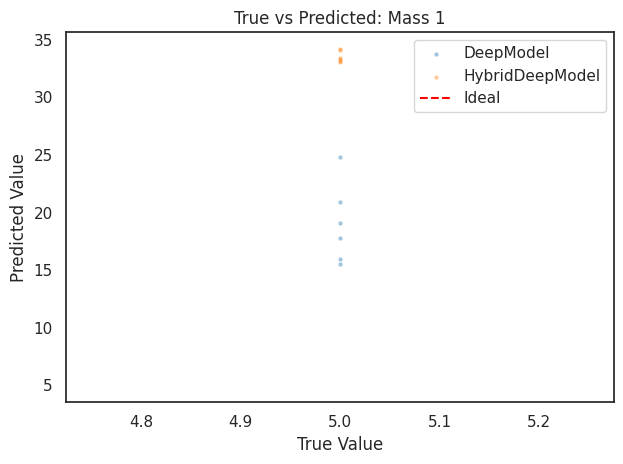

<Figure size 640x480 with 0 Axes>

In [ ]:
# Scatter plot for one key parameter (e.g., primary mass = index 0)
    
# Define your parameter names
param_names = ['Mass 1', 'Mass 2', 'Distance', 'Inclination', 'Spin 1', 'Spin 2'] # Mass 1 --> index=0, Mass 2 --> index=1, etc.

labels = [model.__class__.__name__ for model in models]

# Scatter plot for one key parameter (e.g., primary mass = index 0)
param_index = 0  # Change to the index of the parameter you want <------
plt.figure()
for j, (y_true, y_pred) in enumerate(models_pred):
    plt.scatter(y_true[:, param_index], y_pred[:, param_index], alpha=0.3, label=labels[j], s=5)
plt.plot([all_y_true[:, param_index].min(), all_y_true[:, param_index].max()],
        [all_y_true[:, param_index].min(), all_y_true[:, param_index].max()],
        'r--', label='Ideal')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
# plt.ylim(-10, 120)  #change limits as needed
plt.title(f'True vs Predicted: {param_names[param_index]}')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(f'{destination_folder}/scatter_plot_{param_names[param_index].replace(" ", "_")}.png',
            bbox_inches='tight', dpi=300)


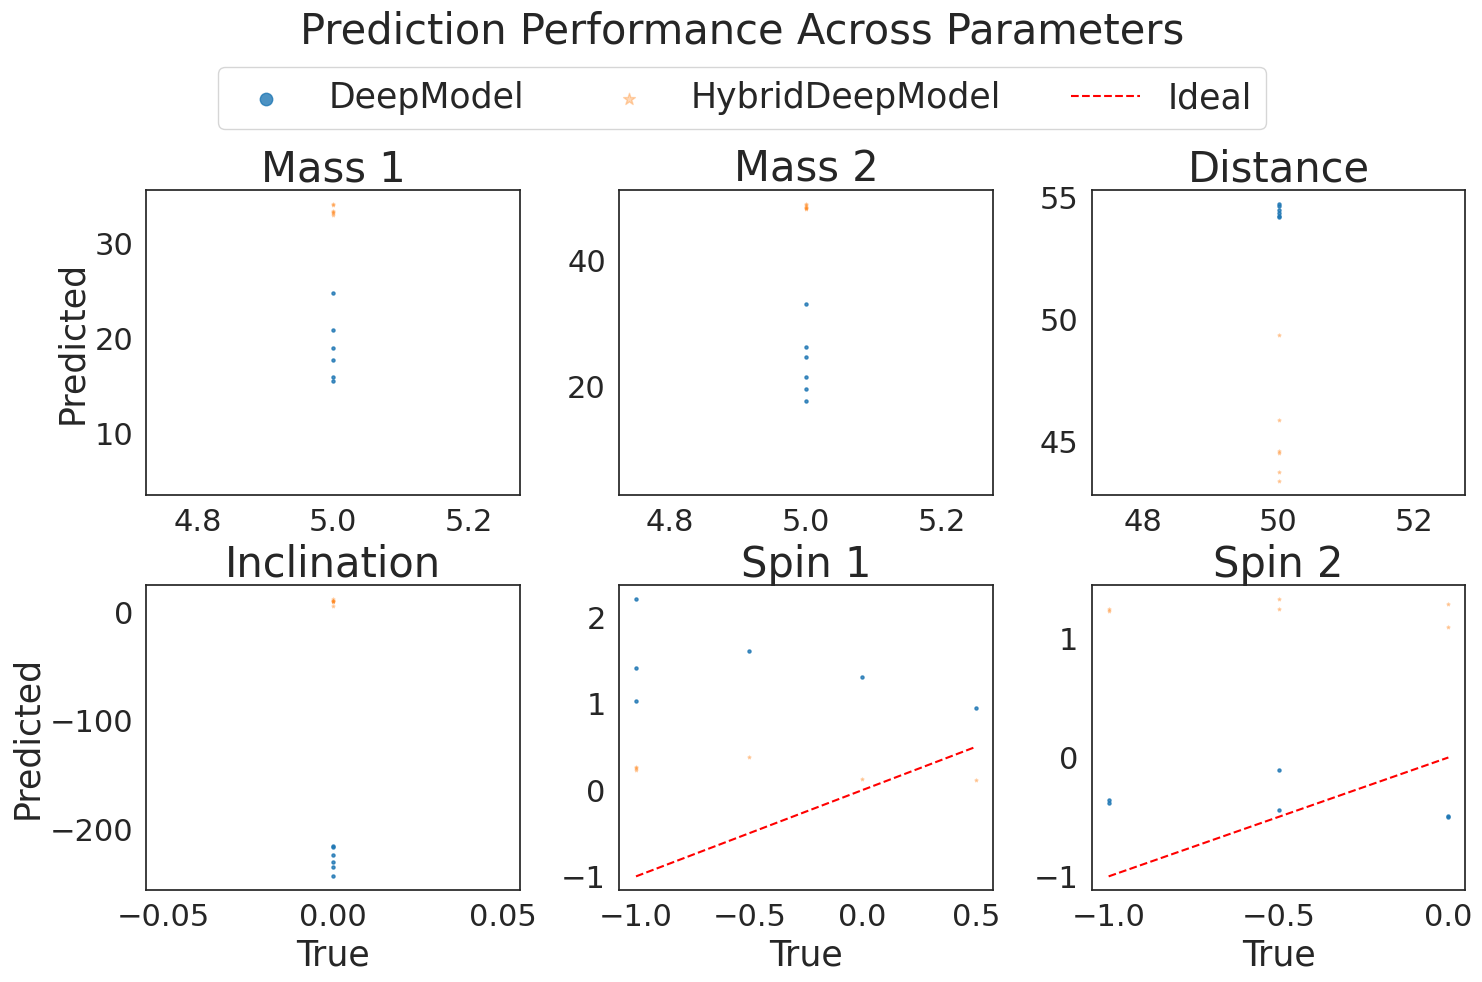

In [15]:
# perfect
fig_width, fig_height = 15, 10
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

scale = fig_width / 6
# Parameter names
param_names = ['Mass 1', 'Mass 2', 'Distance', 'Inclination', 'Spin 1', 'Spin 2']
labels = [model.__class__.__name__ for model in models]


# Loop through subplots
for i, ax in enumerate(axes.flat):
    param_index = i  # Assuming param_index corresponds to i
    for j, (y_true, y_pred) in enumerate(models_pred):
        if j == 0:
            ax.scatter(y_true[:, param_index], y_pred[:, param_index],
                   alpha=0.8, label=labels[j], s=5)
        else:
            ax.scatter(y_true[:, param_index], y_pred[:, param_index],
                   alpha=0.3, label=labels[j], s=5, marker='*')
                
        # Set tick parameters
        ax.tick_params(axis='both', which='major', labelsize=int(9*scale))
        
    # Diagonal line
    min_val = all_y_true[:, i].min()
    max_val = all_y_true[:, i].max()
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
    # ax.set_xlim(all_y_true[:, i].min(), all_y_true[:, i].max())

    # Titles
    ax.set_title(param_names[i], fontsize=int(12*scale))
    
    

    # Conditional axis labels
    row, col = divmod(i, 3)
    if col == 0:  # Left column
        ax.set_ylabel('Predicted', fontsize=int(10*scale))
    else:
        ax.set_ylabel('')  # Remove y-label

    if row == 1:  # Bottom row
        ax.set_xlabel('True', fontsize=int(10*scale))
    else:
        ax.set_xlabel('')  # Remove x-label

# Add one legend for the whole figure
handles, labels_ = axes.flat[0].get_legend_handles_labels()
# fig.legend(handles, labels_, loc='upper right', ncol=len(labels_) + 1)

fig.legend(handles, labels_, loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=len(labels_) + 1, fontsize=int(10 * scale), markerscale=4)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.subplots_adjust(top=0.80)
fig.suptitle('Prediction Performance Across Parameters', fontsize=int(12*scale))

# Save and show
plt.savefig(f'{destination_folder}/true_vs_predicted_grid.png', bbox_inches='tight', dpi=300)
plt.show()